# CC0002 Fake News AI model

In this Notebook, we will be going through how we trained our AI model for **classifying fake news**, implementing knowledge we learnt in **Quantitative Analysis and Artificial Intelligence** to help users discern possible fake news.

In [1]:
# Relevant libraries for quantitative analysis and data visualisation
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set() # set the default Seaborn style for graphics

# Relevant libraries for preprocessing and test/train split
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Import the dataset
We will be importing the (WELFake) dataset from https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification for our model training. The dataset consists of 72,134 news articles with 35,028 real and 37,106 fake news and the real news are aggreagated from four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political). 

In [2]:
# Load the CSV file
true_df = pd.read_csv('True.csv')
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
# Load the CSV file
fake_df = pd.read_csv('Fake.csv')
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Data Preparation and Cleaning

We will now be preparing for our model. We will first combine both the real and fake news datasets provided by the link, and provide labels for them for future supervised learning **(0 - Not Fake, 1 - Fake)**.

Dataset used from: https://www.kaggle.com/datasets/jainpooja/fake-news-detection

In [4]:
# Add a column for data labels for later training
true_df['Fake/Not Fake'] = 0
fake_df['Fake/Not Fake'] = 1

# Concatenate both datasets together 
full_dataset_df = pd.concat([fake_df, true_df], ignore_index=True)

In [5]:
# Check to see if cleaning is required
full_dataset_df.isnull().sum()

title            0
text             0
subject          0
date             0
Fake/Not Fake    0
dtype: int64

As seen above, no Null values are present and all the data within the csv is complete, so no more cleaning is required.

## Quantitative Analysis

1    23481
0    21417
Name: Fake/Not Fake, dtype: int64


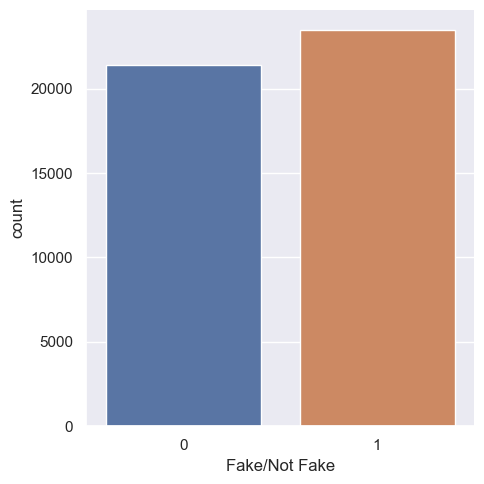

In [20]:
# Data Visualisation
print(full_dataset_df['Fake/Not Fake'].value_counts())
sb.catplot(x = "Fake/Not Fake", data = full_dataset_df, kind = "count")
plt.show()

## Data Preprocessing and Feature Selection

For our model, we will be selecting the following features: title and text to help determine whether the news article/piece of information is likely fake. We believe they are the most valuable features to determine if the news is fake or not as the date of publication and news subject do not convey as much meaningful information to determine the news' legitimacy.

We will now be moving onto preprocessing our data, before it will be ready and suitable for training our model. We will first be tokenising our data.

**Tokenising** <br>
Tokenising is the process of breaking down text into smaller units called tokens. These tokens can be words or numbers. Tokenising is a fundamental step in text processing  and NLP because it helps in understanding the context and developing the structure of the text data. In this project, we will be focusing on word tokenising.

Word Tokenising: This involves splitting a piece of text into individual words. It's useful for tasks that require analysis at the word level, such as frequency distribution analysis, stopwords removal, and word-based filtering, which will be used in our model.

For this project, we will be using the punkt tokeniser.

**Stop word Removal** <br>
Stop word removal is a widely-used preprocessing technique that filters out words that does not convey too much information/meaning such as "the", "a", "is". This helps to improve efficiency as well as improve the overall quality of our training set.

For this project, we will use the library of stop words as prescribed by the NLTK library.

**Stemming**<br>
Stemming in the context of NLP refers to the process of reducing a word to its root meaning(Eg. swimming/swims -> swim). It helps to simplify and standardise words in the processed data to help improve the efficiency of the model as well as its training.

For this project, we will be using the Porter Stemming. 

In [7]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set of English stop words
stop_words = set(stopwords.words('english'))

# Initialize Porter Stemmer
porter = PorterStemmer()

# Shuffle the combined dataset to ensure a random distribution of fake and true news
full_dataset_df = full_dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the structure of the combined dataset and a few random rows to ensure proper combination and shuffling
full_dataset_df.info(), full_dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          44898 non-null  object
 1   text           44898 non-null  object
 2   subject        44898 non-null  object
 3   date           44898 non-null  object
 4   Fake/Not Fake  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\huang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(None,
                                                title  \
 0  Ben Stein Calls Out 9th Circuit Court: Committ...   
 1  Trump drops Steve Bannon from National Securit...   
 2  Puerto Rico expects U.S. to lift Jones Act shi...   
 3   OOPS: Trump Just Accidentally Confirmed He Le...   
 4  Donald Trump heads for Scotland to reopen a go...   
 
                                                 text       subject  \
 0  21st Century Wire says Ben Stein, reputable pr...       US_News   
 1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
 2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
 3  On Monday, Donald Trump once again embarrassed...          News   
 4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   
 
                   date  Fake/Not Fake  
 0    February 13, 2017              1  
 1       April 5, 2017               0  
 2  September 27, 2017               0  
 3         May 22, 2017              1  
 4       June 24

In [8]:
def preprocess_data(text):
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stop words and stemming
    filtered_words = [porter.stem(word) for word in words if word not in stop_words]
    
    # Join words back to text
    text = ' '.join(filtered_words)
    
    return text

Note that the cell below may take a while to run

In [9]:
# Apply preprocessing to both 'title' and 'text'
full_dataset_df['title'] = full_dataset_df['title'].apply(preprocess_data)
full_dataset_df['text'] = full_dataset_df['text'].apply(preprocess_data)

# Combining 'title' and 'text' into a single column for simplicity
full_dataset_df['combined_text'] = full_dataset_df['title'] + " " + full_dataset_df['text']

# Display the structure and first few rows of the processed dataframe to verify preprocessing
full_dataset_df[['combined_text', 'Fake/Not Fake']].head()

,combined_text,Fake/Not Fake
0,ben stein call 9th circuit court commit coup é...,1
1,trump drop steve bannon nation secur council w...,0
2,puerto rico expect u lift jone act ship restri...,0
3,oop trump accident confirm leak isra intellig ...,1
4,donald trump head scotland reopen golf resort ...,0


**Test-train split**<br>
To test the future effectiveness of our model, we will be splitting our data into a test set and train set. The train set will be used to fit the vectoriser and train the model while our test set will be used to evaluate our model performance. The split is done randomly so that both sets will have a good representation of our data. The split is also done so that our evaluation will be on data that the model has not seen before, and thus more accurately shows how the model fairs to general real-time news data, that our users will be interacting with.

**Vectorising**<br>
Vectorisation in NLP is a method to convert text data into a numerical representation so that the ML algorithms can understand the process the text data better. 

We will be using Term Frequency-Inverse Document Frequency(TF_IDF) vectorisation method to assign more weight to words that are more unique and thus more important in our classification.


In [10]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    full_dataset_df['combined_text'], full_dataset_df['Fake/Not Fake'], test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the training data, and transform the testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shape of the resulting TF-IDF matrices
(X_train_tfidf.shape, X_test_tfidf.shape)

((35918, 10000), (8980, 10000))

## Training different Machine Learning Models

We will now test our data on different machine learning models and test to see which one is best in predicting fake news.<br>
We will be testing 4 different models:
- **Logistic Regression** (classical method for binary classification)
- **Naive Bayes Classifier** (Good for high dimensional data, like our own test/train set)
- **Passive Aggressive Classifier** (Updates itself aggressively when dealing with misclassification, making it more robust in dealing with noise and better for fake news)
- **Support Vector Machine** (Good for high dimensional data, like our own test/train set)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training set
lr_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.9860801781737194
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4270
           1       0.99      0.98      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [25]:
from sklearn.naive_bayes import MultinomialNB

# Initialise the Naive Bayes classifier model
nb_model = MultinomialNB()

# Train the model on the training set
nb_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.9304008908685969
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4270
           1       0.93      0.94      0.93      4710

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [26]:
from sklearn.linear_model import PassiveAggressiveClassifier

# Initialise the Passive Aggressive Classifier model
pa_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42)

# Train the model on the training set
pa_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred_pa = pa_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_pa))
print(classification_report(y_test, y_pred_pa))

Accuracy: 0.9935412026726058
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4270
           1       0.99      0.99      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [27]:
from sklearn.svm import LinearSVC

# Initialize the Support Vector Machine model
svm_model = LinearSVC(random_state=42)

# Train the model on the training set
svm_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.9943207126948775
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4270
           1       1.00      0.99      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## Model Evaluation

We will now be evaluating our models, and determining which one is best for detecting fake news. We will be utilising 2 metrics to decide which model is the best: **accuracy and recall**. 

Accuracy refers to percentage of correct classifications made by the model. 

Recall measures the probability that a piece of fake news correctly identified amongst all the actual fake news. 

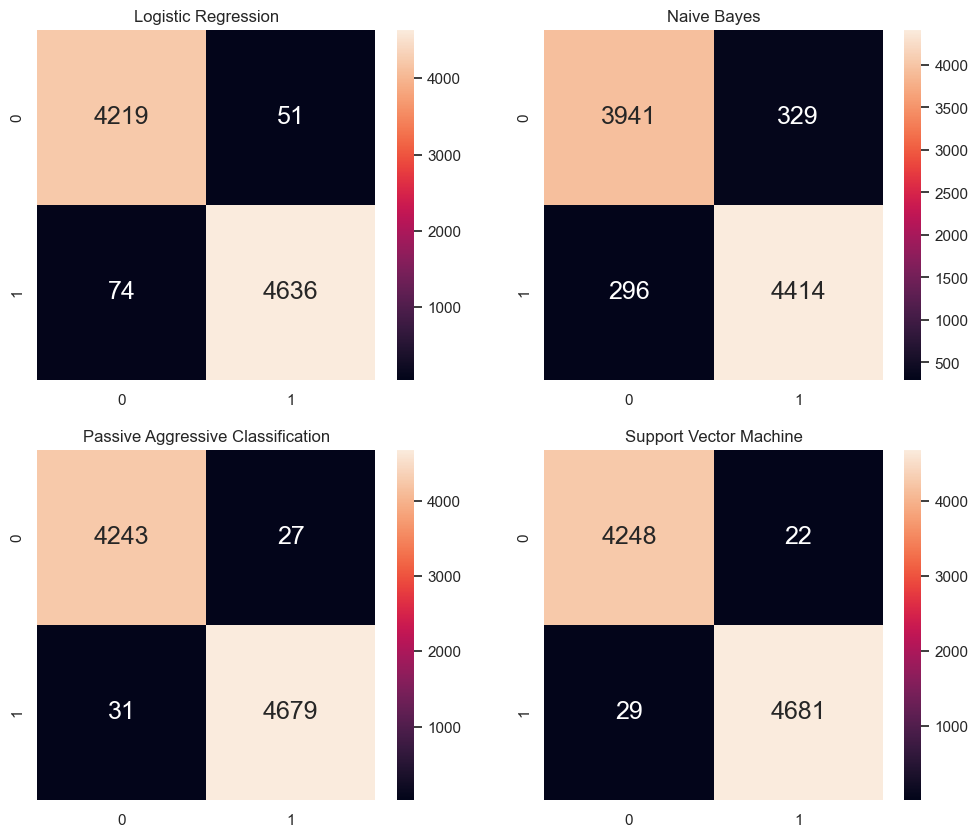

In [15]:
from sklearn.metrics import confusion_matrix

f, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0][0].set_title("Logistic Regression")
axes[0][1].set_title("Naive Bayes")
axes[1][0].set_title("Passive Aggressive Classification")
axes[1][1].set_title("Support Vector Machine")
sb.heatmap(confusion_matrix(y_test, y_pred_lr),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0][0])
sb.heatmap(confusion_matrix(y_test, y_pred_nb), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0][1])
sb.heatmap(confusion_matrix(y_test, y_pred_pa), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1][0])
sb.heatmap(confusion_matrix(y_test, y_pred_svm), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1][1])
plt.show()

Above shows the confusion matrix (a matrix to show the different numbers of True Positive, True Negative, False Positive and False Negative Rates) to better visualise which models are better.

In [29]:
# Print the score of each model
print("Logistical Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=8))

print("Naive Bayes Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, digits=8))

print("Passive Aggressive Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_pa))
print(classification_report(y_test, y_pred_pa, digits=8))

print("Support Vector Machine")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=8))

Logistical Regression
Accuracy: 0.9860801781737194
              precision    recall  f1-score   support

           0  0.98276264 0.98805621 0.98540231      4270
           1  0.98911884 0.98428875 0.98669788      4710

    accuracy                      0.98608018      8980
   macro avg  0.98594074 0.98617248 0.98605010      8980
weighted avg  0.98609646 0.98608018 0.98608184      8980

Naive Bayes Classifier
Accuracy: 0.9304008908685969
              precision    recall  f1-score   support

           0  0.93013925 0.92295082 0.92653109      4270
           1  0.93063462 0.93715499 0.93388342      4710

    accuracy                      0.93040089      8980
   macro avg  0.93038693 0.93005290 0.93020726      8980
weighted avg  0.93039907 0.93040089 0.93038738      8980

Passive Aggressive Classifier
Accuracy: 0.9935412026726058
              precision    recall  f1-score   support

           0  0.99274684 0.99367681 0.99321161      4270
           1  0.99426264 0.99341826 0.99384027

As seen above, amongst all the machine learning models, the support vector machine has both the best accuracy as well as the best recall. Therefore, we will be utlising it in our plug-in!

## Our Model in Action

Now that we have our model, lets try to test on some data on the internet! 

We will use beautifulsoup to scrap news title and news content from live websites and parsing these data to our model to evaluate its effectiveness in detecting possible fake news.

In [17]:
# Install the relevant modules to check url and extract title and content
!pip install requests
!pip install beautifulsoup4

In [18]:
import requests
from bs4 import BeautifulSoup

# Define function to parse the url to extract HTML information
def download_and_parse_html(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

# Extract title and news content from the HTML information
def extract_news_content(soup):
    # Extract title from the header '<h1>' tag
    title = soup.find('h1').get_text()
    
    # Extract news content from within <p> tags in a specific div
    content = ' '.join(p.get_text() for p in soup.find_all('p'))
    
    return title, content

# With the above helper functions extract relevant information from the website 
# and run it through the ML model for classification
def classify_news(url):
    soup = download_and_parse_html(url)
    title, content = extract_news_content(soup)
    
    # Preprocess the data so that it can be inputted into the model
    title = preprocess_data(title)
    content = preprocess_data(content)
    data = [{"data": title + " " + content}]
    combined_df = pd.DataFrame(data)
    vectorised_data = tfidf_vectorizer.transform(combined_df['data'])
    
    # Make the prediction and print the result
    prediction = svm_model.predict(vectorised_data)
    print("Likely Fake") if prediction else print("Likely True")

In [19]:
classify_news("https://www.channelnewsasia.com/singapore/automation-training-initiatives-among-proposed-solutions-singapores-marine-sector-braces-manpower-crunch-4211401")

Likely True


**TEST CASES**<br>
Fake<br>
https://www.theonion.com/shitty-music-has-helped-moron-through-hardest-times-in-1848340506

https://www.newyorker.com/magazine/2024/03/25/the-crime-rings-stealing-everything-from-purses-to-power-tools

True<br>
https://www.channelnewsasia.com/singapore/automation-training-initiatives-among-proposed-solutions-singapores-marine-sector-braces-manpower-crunch-4211401

https://edition.cnn.com/2024/03/21/asia/us-tests-hypersonic-missile-pacific-guam-intl-hnk-ml/index.html